In [1]:
# 1. Forecast with numeric timeseries data
# 1.1 Roaming Data의 load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
# custom R2-score metrics for keras backend
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def plot_mae(hist):
    plt.plot(hist.history['mae'])
    plt.title('mean_absolute_error')
    plt.ylabel('mae')
    plt.xlabel('Epoch')
    plt.legend(['mae'], loc='upper right')
    plt.show()

def plot_r2(hist):
    plt.plot(hist.history['r2'])
    plt.title('R square')
    plt.ylabel('R^2')
    plt.xlabel('Epoch')
    #plt.legend(['mae'], loc='upper right')
    plt.show()

def compare_backdata(predit_y):
    predit = []
    for forecast in range(forecast_days):
        predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    comp_ds = raw_ds.copy()
    comp_ds['predict_arrival_1'] = predit[0]
    comp_ds['predict_arrival_15'] = predit[14]
    comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))

def display_result(predit_y):
    predic_ds = []
    # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
    #predit_y1 = predit_y * 100/24
    from datetime import datetime, timedelta
    last_date = raw_ds.index[-1]
    for predict_count in predit_y[0]:
        last_date += timedelta(days=1)
        predic_ds.append({'date':last_date,'roaming register forecate':predict_count, 'immigrantion forecast':int(predict_count * 100/24)})
    predic_ds = pd.DataFrame(predic_ds)
    predic_ds.plot(x='date',y='immigrantion forecast',kind='bar')
    return predic_ds

class VerboseCallback(keras.callbacks.Callback):
    def __init__(self,epoch):
        self.epoch = epoch
        self.progress("learning:",0,[])
        
    def progress(self,text,current=0,log=None):
        pg = ['=' for i in range(current)] + ['.' for i in range(self.epoch-current)]
        print("\r" + str(text) + "[{}] {}/{} {}".format(''.join(pg),current,self.epoch, ('' if log is None else log)), end="", flush=True)
        if self.epoch-current == 0:
            print("")        
            
    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:",epoch+1,logs)



Using TensorFlow backend.


In [2]:
#공개된 Roaming Dataset을 읽고, 중간 중간 나온것을 합친다.
rm1 = pd.read_csv("./corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("./corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm = pd.concat([rm1, rm2], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
217800,20200401,vn,20200330,20200401,3
217801,20200401,vn,20200331,20200331,20
217802,20200401,vn,20200331,20200401,6
217803,20200401,vn,20200401,20200401,45


In [3]:
# 1.2 Roaming Data에 대한 EDA
# 1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산

ar = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ar['date'] =  ar.index.astype('object')
#date column을 datetime 으로 casting 한다.
ar['date'] =  pd.to_datetime(ar['date'], format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ar

,count,date
arrival,,
20191031,91,2019-10-31
20191101,36,2019-11-01
20191102,120,2019-11-02
20191103,159,2019-11-03
20191104,179,2019-11-04
...,...,...
20200424,711,2020-04-24
20200425,463,2020-04-25
20200426,447,2020-04-26


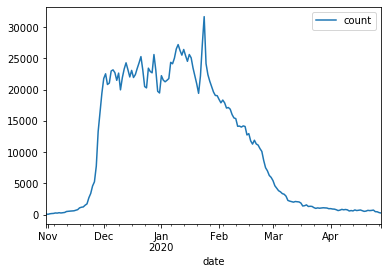

In [4]:
# 1.2.2 입국자(로밍등록자) 추세 chart 확인
ar.plot(x='date',y='count')

In [5]:
# 1.3 Roaming Data의 전처리
# 1.3.1 iso 별로 재배열

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
    if date == row[0][0]:
        pass
    else:
        if not r is None:
            rows.append(r)
        r = {}
    r['arrival'] = row[0][0]
    r[row[0][1]] = row[1][0]
    date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso

,ae,at,cn,de,hk,jp,kh,kw,la,mm,...,tc,ls,td,mr,to,ws,gm,ye,ml,total
arrival,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447


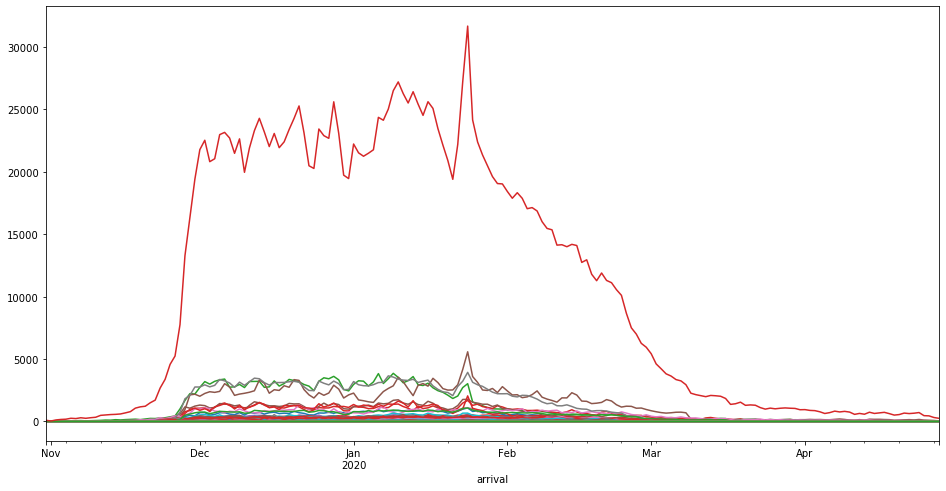

In [6]:
ds_iso.plot(legend=False,figsize=(16,8))

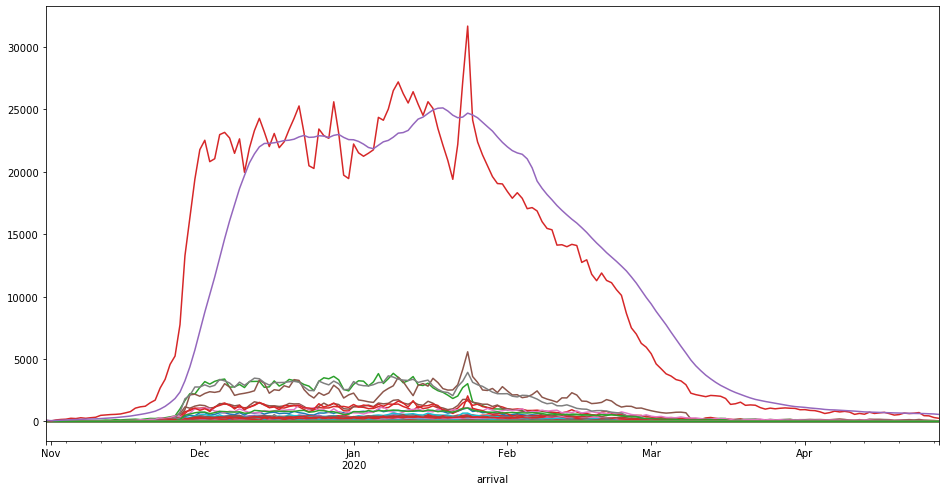

In [7]:
# 1.3.2 2주 (14일) 평균 추세 추가.
raw_ds = ds_iso.copy()
raw_ds['arrival_14ma'] = raw_ds['total'].rolling(window=14, min_periods=0).mean()
raw_ds.plot(legend=False,figsize=(16,8))

In [8]:
# 1.3.3 Trainingset의 구성

# Time-series CNN을 적용하기 위한 전처리
# 1D Convolution을 적용하기 위해.

import numpy as np

# window를 30일로 설정 -> 그냥 잡은 수치
window = 30
#입력 feature 개수.
size = len(raw_ds.columns) - 1 # totoal column 제외
#향후 15일 예측
forecast_days = 15


train_org_y = raw_ds['total'].to_numpy()
data = (raw_ds.drop(columns=['total'])).to_numpy()

train_x = []
train_y = []

for i in range(data.shape[0]-window-forecast_days + 1):
    sub_x = []
    for j in range(window):
        sub_x.append(data[i+j,:])
    train_x.append(sub_x)

    sub_y = []
    for z in range(forecast_days):
        sub_y.append(train_org_y[i + window + z])
    train_y.append(sub_y)

#train_x ,train_y의 준비
train_x = np.asarray(train_x)
train_x = train_x.reshape(-1,window,size)
train_y = np.asarray(train_y)

test_x = data[data.shape[0]-window:data.shape[0],:]

In [9]:
#train_x ,train_y의 내용 확인.
train_x.shape, train_y.shape, test_x.shape

((137, 30, 174), (137, 15), (30, 174))

In [10]:
# 1.4 CNN model 구성 

# custom R2-score metrics for keras backend
from keras import backend as K

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,4, input_shape=(window, size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(32))
model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           89216     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 64)            32832     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 32)            

In [11]:
# 1.5 model training
# 1.5.1 model training

#학습 시작...
epochs=50
hist = model.fit(train_x, train_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[==================================================] 50/50 {'loss': 3541494.4069343065, 'mae': 1285.9167, 'r2': 0.9622275}}


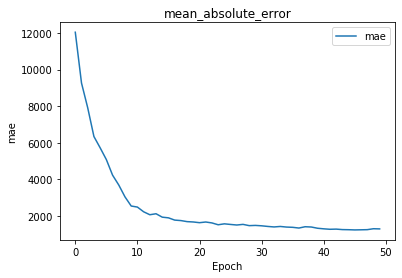

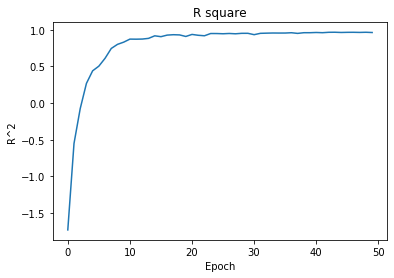

In [12]:
# 1.5.2 학습에 대한 mean_absolute_error 확인.
plot_mae(hist)
plot_r2(hist) 

In [13]:
# 1.5.3 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_x)
predit_y,predit_y.shape

(array([[14825.569  , 14993.244  , 14976.669  , ..., 17051.639  ,
         17981.559  , 16370.358  ],
        [18704.094  , 18685.607  , 18667.963  , ..., 21310.672  ,
         22183.377  , 20467.48   ],
        [21353.314  , 21285.43   , 21153.156  , ..., 24094.223  ,
         24708.268  , 23484.545  ],
        ...,
        [  683.614  ,   594.321  ,   637.193  , ...,   364.85953,
           319.24298,   278.40314],
        [  649.58655,   560.26215,   605.7104 , ...,   352.88956,
           295.90137,   261.46304],
        [  632.434  ,   557.74963,   618.2753 , ...,   366.77206,
           299.40112,   277.7664 ]], dtype=float32),
 (137, 15))

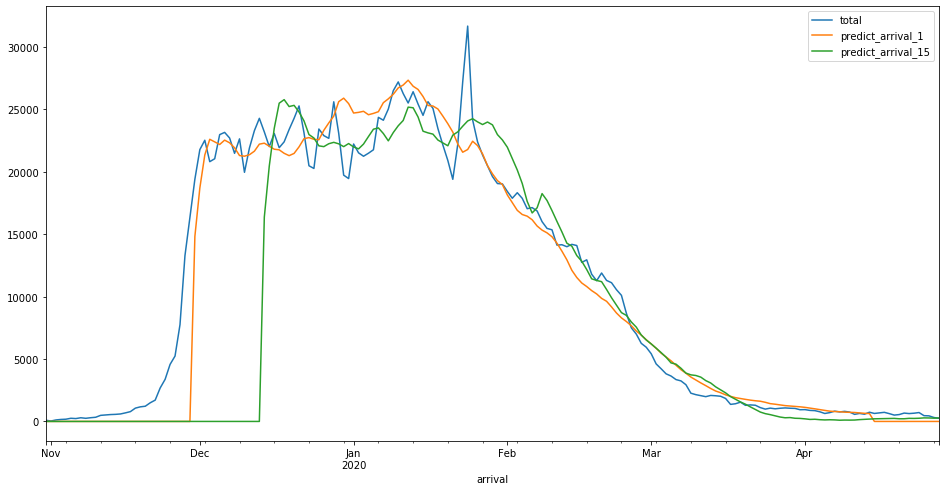

In [14]:
# 1.5.4 과거 Data에서 실등록자 count와 예측 count의 비교 

def compare_backdata(predit_y):
    predit = []
    for forecast in range(forecast_days):
        predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    comp_ds = raw_ds.copy()
    comp_ds['predict_arrival_1'] = predit[0]
    comp_ds['predict_arrival_15'] = predit[14]
    comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))

compare_backdata(predit_y)

In [15]:
# 1.6  향후 15일 예측
# 1.6.1 testset (마지막 30일)의 inference

# trainset의 마지막 날에서 15일까지의 예측
# 마지막 30일치 정보를 input으로...

test_x = test_x.reshape(-1,window,size)
predit_y = model.predict(test_x)
predit_y, predit_y.shape

(array([[388.319  , 335.1624 , 347.7613 , 346.8553 , 322.52823, 299.0659 ,
         307.7701 , 305.28513, 261.47287, 264.7009 , 249.31099, 239.58934,
         235.62184, 184.27887, 201.88858]], dtype=float32),
 (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,388.319000,1617
1,2020-04-30,335.162415,1396
2,2020-05-01,347.761292,1449
3,2020-05-02,346.855286,1445
4,2020-05-03,322.528229,1343
5,2020-05-04,299.065887,1246
6,2020-05-05,307.770111,1282
7,2020-05-06,305.285126,1272
8,2020-05-07,261.472870,1089
9,2020-05-08,264.700897,1102


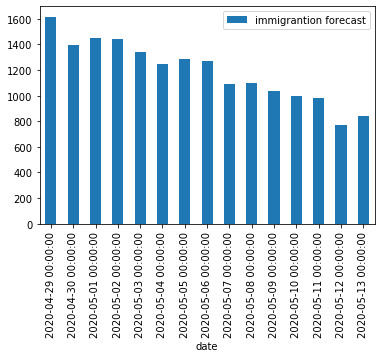

In [16]:
# 1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [17]:

# 	2.1 News Data의 load

# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("./corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("./corona_contest_data_0429/NewsList.xls")
ns =pd.concat([ns1, ns2], ignore_index=True, sort=False)

In [18]:
ns

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
103822,XWFB2020040900020,"Ching Ming remembrance, home country forever! ...",http://wsjkw.sh.gov.cn/xwfb/20200404/2f54e0e14...,2020-04-09 16:05:21.0,2020-04-04 00:00:00,Shanghai Municioal Health Commission,COVID-19,Viral
103823,ZWYW2020041000002,Guangdong Provincial Health Commission notifie...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-10 18:00:45.0,2020-04-10 00:00:00,Health Commission of Guangdong Province,Dengue fever,Viral
103824,ZWYW2020041500002,Guangdong Provincial Health Commission announc...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:04.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral
103825,ZWYW2020041500003,Guangdong Provincial Health Commission release...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:13.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral


In [19]:
# 	2.2 News Data에 대한 EDA
# 		2.2.1 게시일을 기준으로 News buzz의 합산

cov_news = ns.loc[ns['감염병명'] == 'COVID-19']
cov_news['게시일자'] =  cov_news['게시일자'].str[:10]
cov_buz = pd.DataFrame(cov_news.groupby('게시일자')['감염병명'].count())
cov_buz = cov_buz.loc[cov_buz.index >= '2019-10-31']
cov_buz['date'] = pd.to_datetime(cov_buz.index, format='%Y-%m-%d')
cov_buz = cov_buz.rename(columns={"감염병명":"buz_count"})
cov_buz

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,buz_count,date
게시일자,,
2019-12-01,1,2019-12-01
2019-12-14,2,2019-12-14
2019-12-30,3,2019-12-30
2019-12-31,5,2019-12-31
2020-01-02,1,2020-01-02
...,...,...
2020-04-26,1176,2020-04-26
2020-04-27,1353,2020-04-27
2020-04-28,999,2020-04-28


In [20]:
# 		2.2.2 하루 최대 buzz count 추출

max_buz_per_day = cov_buz['buz_count'].max()
max_buz_per_day

1948

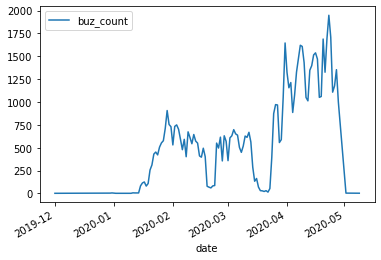

In [21]:
# 		2.2.3 News buzz 추세 Chart

cov_buz.plot(x='date',y='buz_count')

In [23]:
# Sentence Transformers: Multilingual Sentence Embeddings using BERT / RoBERTa / XLM-RoBERTa & Co. with PyTorch
# https://github.com/UKPLab/sentence-transformers

!pip install -U sentence-transformers

# BERT Test Code...

"""
This is a simple application for sentence embeddings: semantic search
We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

from sentence_transformers import SentenceTransformer
import scipy.spatial

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]

corpus_embeddings = embedder.encode(corpus)

# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']
query_embeddings = embedder.encode(queries)

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
closest_n = 5

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")
    for idx, distance in results[0:closest_n]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))

You should consider upgrading via the 'c:\program files\python36\python.exe -m pip install --upgrade pip' command.


Requirement already up-to-date: sentence-transformers in c:\program files\python36\lib\site-packages (0.2.6.1)




Query: A man is eating pasta.

Top 5 most similar sentences in corpus:
A man is eating a piece of bread. (Score: 0.8480)
A man is eating food. (Score: 0.7759)
Two men pushed carts through the woods. (Score: 0.2095)
A monkey is playing drums. (Score: 0.1945)
A man is riding a white horse on an enclosed ground. (Score: 0.1586)




Query: Someone in a gorilla costume is playing a set of drums.

Top 5 most similar sentences in corpus:
A monkey is playing drums. (Score: 0.7985)
A cheetah is running behind its prey. (Score: 0.2860)
The girl is carrying a baby. (Score: 0.2351)
A man is riding a horse. (Score: 0.2023)
A man is riding a white horse on an enclosed ground. (Score: 0.1963)




Query: A cheetah chases prey on across a field.

Top 5 most similar sentences in corpus:
A cheetah is running behind its prey. (Score: 0.9007)
Two men pushed carts through the woods. (Score: 0.3

In [30]:
#			2.3.1.1 document의 tokenize & tagging
# 실 Contents는 사용하지 않고 title만 BERT embedding 처리...
import os.path
from os import path
import dill

if path.exists("corpus_embeddings.emb"):
    print("load from corpus_embeddings file...")
    file = open("corpus_embeddings.emb", 'rb')
    corpus_embeddings = dill.load(file)
    file.close()
    print("Complete!!")
else:
    temp_ds = cov_news #.head(10)
    corpus = []
    for row in temp_ds.iterrows():
        file_name = row[1][0]
        title = str(row[1][1])
        pub_datetime = row[1][4]
        corpus.append(title.lower())

    corpus_embeddings = embedder.encode(corpus,show_progress_bar=True)   

    print("Wait! saving corpus_embeddings...")    
    file = open("corpus_embeddings.emb", 'wb')
    dill.dump(corpus_embeddings, file)
    file.close()
    print("Complete!!")

corpus_embeddings = np.asarray(corpus_embeddings)        
print("shape of corpus_embeddings : ",corpus_embeddings.shape)

temp_ds = cov_news #.head(10)
docv_model = {}
for i, row in enumerate(temp_ds.iterrows()):
    docv_model[row[1][0]] = corpus_embeddings[i]

len(docv_model)

load from corpus_embeddings file...
Complete!!
shape of corpus_embeddings :  (73752, 768)


73306

In [31]:
#		2.3.4 원시(origin) Trainset의 구성

# BERT embedding 처리한 뉴스 원시 학습셋을 구성한다.
# 이때, 입국일자을 기준으로 Set을 만드는데...
# 입국일에 news가 없을 때도 있어서, 일관성 있는 양질의 학습셋이 되기는 어려울 듯...
# 준대로 해야지 어쩔 수 없음.

vec_size = corpus_embeddings.shape[1]
max_buz_per_day = 300 # 하루에 최대 300개의 뉴스를 본다. 나중에 실재 최대치까지 증가..
cov_news['게시일자'] = pd.to_datetime(cov_news['게시일자'], format='%Y-%m-%d')
news_metric = []
from datetime import datetime, timedelta
import numpy as np
# 날짜별 구성
for row in ar.iterrows():
    date = row[1][1]#datetime(2019,12,31)
    selected_ns = cov_news.loc[cov_news['게시일자'] >= date].loc[cov_news['게시일자'] < (date + timedelta(days=1))]
    #print(date,selected_ns.shape)
    if selected_ns.shape[0] == 0:
        # news가 없는 경우..
        news_metric.append(np.zeros((max_buz_per_day,vec_size)))
    else:
        docv = []
        for nrow in selected_ns.iterrows():
            #print('tag name:',nrow[1][0])
            if len(docv) < max_buz_per_day:
                docv.append(docv_model[nrow[1][0]])
        if len(docv) < max_buz_per_day:
            for i in range(max_buz_per_day-selected_ns.shape[0]):
                docv.append(np.zeros(vec_size))
        news_metric.append(docv)
        
train_temp_x = np.asarray(news_metric)
train_temp_x.shape


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(181, 300, 768)

In [97]:
# News에서 6개 feature 추출
# worse feature : 코로나 상황이 더 나빠지고 있다는 뉴스
# better feature : 상황이 좋아 지고 있나는 뉴스
# block feature : 격리, 입출입 차단 강화 관련 뉴스
# premit feature : 격리 해제, 입출입 완화 관련 뉴스
# yes_korea feature : 한국에 긍정적 내용 뉴스
# no_korea feature : 한국에 부정적 내용 뉴스

def searchSentence(queries,Threshold_score=0.60, Topn=0,must_has_word=[]):
    index = [],score = []
    query_embeddings = embedder.encode(queries)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        
        for idx, distance in results[0:len(results) if Topn==0 else Topn]:
            if (1-distance) > Threshold_score:
                if len(must_has_word) > 0:
                    if corpus[idx].strip().find(must_has_word[0]) >= 0:
                        index.append(idx)
                else:
                    index.append(idx)
                #print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))
    return index

cov_news.reset_index(inplace = True, drop = True) 

worse = ['infected corona','infected coronavirus ','increase confirmed','increase Infections','infectious increase','confirmed case incease','deaths incease','patients incease','lack prepare','not prepared','lack medical','lack preparedness']
better = ['decrease confirmed','decrease Infections','infectious decrease','confirmed case decrease','No confirmed','No case','deaths decrease','patients decrease','send supplies','order supplies','donates supplies','gives supplies','situation stability','situation stable','remains stable']
block = ['immigrants block','immigrants restrict','immigration block','immigration restrict','entrants block','entrants restrict','entry block','entry restrict','tourist block','tourist restrict','tourist Isolation','traveler block','traveler restrict','traveler Isolation','immigrants quarantine','entrants quarantine','entry quarantine','tourist quarantine','reinforce quarantine','reinforce diagnosis']
permit = ['immigrants permit','immigrants ease','immigration permit','immigration ease','entrants permit','entrants ease','entry permit','entry ease','tourist permit','tourist ease','release tourist ','traveler permit','release quarantine','release quarantine']
yes_korea = ['korea decrease confirmed','korea decrease Infections','korea infectious decrease','korea confirmed case decrease','korea No confirmed','korea No case','korea deaths decrease','korea patients decrease','korea send supplies','korea order supplies','korea donates supplies','korea gives supplies','korea situation stability','korea situation stable','korea remains stable','korea immigrants permit','korea immigrants ease','korea immigration permit','korea immigration ease','korea entrants permit','korea entrants ease','korea entry permit','korea entry ease','korea tourist permit','korea tourist ease','korea release tourist ','korea traveler permit','korea release quarantine','korea release quarantine']
no_korea = ['korea infected corona','korea infected coronavirus ','korea increase confirmed','korea increase Infections','korea infectious increase','korea confirmed case incease','korea deaths incease','korea patients incease','korea lack prepare','korea not prepared','korea lack medical','korea lack preparedness','korea immigrants block','korea immigrants restrict','korea immigration block','korea immigration restrict','korea entrants block','korea entrants restrict','korea entry block','korea entry restrict','korea tourist block','korea tourist restrict','korea tourist Isolation','korea traveler block','korea traveler restrict','korea traveler Isolation','korea immigrants quarantine','korea entrants quarantine','korea entry quarantine','korea tourist quarantine','korea reinforce quarantine','korea reinforce diagnosis']

# Query sentences:
cov_news['worse'] = 0
idxs, = searchSentence(worse)
print('worse result rows:{} query count:{}'.format(len(idxs),len(worse)))
cov_news.loc[idxs,'worse'] = 1

cov_news['better'] = 0
idxs = searchSentence(better)
print('better result rows:{} query count:{}'.format(len(idxs),len(better)))
cov_news.loc[idxs,'better'] = 1

cov_news['block'] = 0
idxs = searchSentence(block)
print('block result rows:{} query count:{}'.format(len(idxs),len(block)))
cov_news.loc[idxs,'block'] = 1

cov_news['permit'] = 0
idxs = searchSentence(permit)
print('permit result rows:{} query count:{}'.format(len(idxs),len(permit)))
cov_news.loc[idxs,'permit'] = 1

cov_news['yes_korea'] = 0
idxs = searchSentence(yes_korea,must_has_word=['korea'])
print('yes_korea result rows:{} query count:{}'.format(len(idxs),len(yes_korea)))
cov_news.loc[idxs,'yes_korea'] = 1

cov_news['no_korea'] = 0
idxs = searchSentence(no_korea,must_has_word=['korea'])
print('no_korea result rows:{} query count:{}'.format(len(idxs),len(no_korea)))
cov_news.loc[idxs,'no_korea'] = 1


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


worse result rows:11805 query count:12


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


better result rows:1378 query count:15


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


block result rows:2411 query count:20


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


permit result rows:1210 query count:14


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


yes_korea result rows:574 query count:29


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


no_korea result rows:2049 query count:32


In [107]:
cov_1 = pd.DataFrame(cov_news.groupby('게시일자')['worse'].sum()/cov_buz['buz_count'])
cov_2 = pd.DataFrame(cov_news.groupby('게시일자')['better'].sum()/cov_buz['buz_count'])
cov_3 = pd.DataFrame(cov_news.groupby('게시일자')['block'].sum()/cov_buz['buz_count'])
cov_4 = pd.DataFrame(cov_news.groupby('게시일자')['permit'].sum()/cov_buz['buz_count'])
cov_5 = pd.DataFrame(cov_news.groupby('게시일자')['yes_korea'].sum()/cov_buz['buz_count'])
cov_6 = pd.DataFrame(cov_news.groupby('게시일자')['no_korea'].sum()/cov_buz['buz_count'])

cov_buz = cov_buz.join(cov_1).join(cov_2).join(cov_3).join(cov_4).join(cov_5).join(cov_6)
cov_buz

ValueError: columns overlap but no suffix specified: Index([0], dtype='object')

In [103]:
norm_cov_buz = cov_buz['worse']/cov_buz['buz_count']

In [104]:
norm_cov_buz

게시일자
2019-12-01    0.000000
2019-12-14    0.000000
2019-12-30    0.333333
2019-12-31    0.600000
2020-01-02    0.000000
                ...   
2020-04-26    0.066327
2020-04-27    0.068736
2020-04-28    0.081081
2020-05-02    0.000000
2020-05-09    0.000000
Length: 121, dtype: float64

c:\program files\python36\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\program files\python36\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\program files\python36\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\program files\python36\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\program files\python36\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\program files\python36\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49884 missing fr

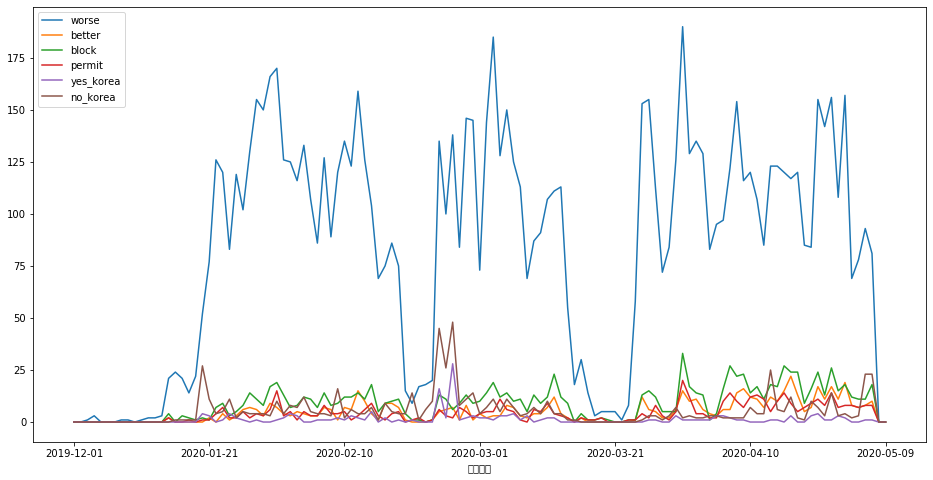

In [102]:
cov_buz.plot(y=['worse','better','block','permit','yes_korea','no_korea'],figsize=(16,8))

In [22]:
# 	2.3 News Data의 전처리
#		2.3.1 News Data의 doc2vec 처리

!pip install nltk
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

You should consider upgrading via the 'c:\program files\python36\python.exe -m pip install --upgrade pip' command.
unable to import 'smart_open.gcs', disabling that module


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\똘마니\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
#			2.3.1.1 document의 tokenize & tagging
# 실 Contents는 사용하지 않고 title만 doc2vec 처리...
tagged_data = []
for row in cov_news.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    tagged_data.append(TaggedDocument(words=word_tokenize(title.lower()), tags=[file_name]))
    
len(tagged_data)

73752

In [66]:
#			2.3.1.2 doc2vec model training
# 시간 무지 걸림... 돌리고 커피 한잔 마시기.

max_epochs = 100 # 이건 나중에 100 정도로 수정...
vec_size = 20 # 나중에 증가 시킨다.contents를 사용하는 경우, 500~1000정도 ?? 하지만 학습시간은 무지 걸릴거임.
alpha = 0.025

d2v_model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
d2v_model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    d2v_model.train(tagged_data,
                total_examples=d2v_model.corpus_count,
                epochs=d2v_model.epochs )
    # decrease the learning rate
    d2v_model.alpha -= 0.0002
    # fix the learning rate, no decay
    d2v_model.min_alpha = d2v_model.alpha

d2v_model.save("d2v.model")

print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [67]:
# doc2vec 모델 학습 결과 확인..
from gensim.models.doc2vec import Doc2Vec

d2v_model= Doc2Vec.load("d2v.model")

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(d2v_model.docvecs['AFRO2020013100001'])

[-0.09168762 -1.3434651  -3.9382987   1.1648774  -2.5846615   5.5267467
 -0.6252161   1.9472437   0.96257377 -3.8087997  -0.62035877  6.2193165
 -1.600687    0.1740714  -2.3033636   1.6573902  -3.2979834   2.7497995
  0.45020556 -0.2507372 ]


In [27]:
# News를 labeling 할 수 없으므로, 아래와 같이 6개의 요소로 구분하여 0,1으로 구분 한다.
'''
1. worse
-> 진단자(confirme,confirmed,Infections, Infected,infectious ), 사망자(death, deaths,die,patients) 증가(increases,increased), 준비(prepare,preparedness) 허술/부족(Lack ), 의료 부실
. infected corona
. infected coronavirus 
. increase confirmed
. increase Infections
. infectious increase
. confirmed case incease
. deaths incease
. patients incease
. lack prepare
. not prepared
. lack medical
. lack preparedness

2. Better
-> 진단자, 사망자 감소(No, Not, decrease), 안정세(stability,stable), 지원(supplies,supply)
. decrease confirmed
. decrease Infections
. infectious decrease
. confirmed case decrease
. No confirmed
. No case
. deaths decrease
. patients decrease
. send supplies
. order supplies
. donates supplies
. gives supplies
. situation stability
. situation stable
. remains stable

3. block
-> 입국자(immigrants,immigrated,immigration,entry,entrants ) 차단(block, blocked,restricts,restrict), 격리(Isolation), 관광객(tourist, tourists,travelers ) 방역/검역(quarantine,quarantined), 진단(Diagnosis) 강화(reinforce)/증가
. immigrants block
. immigrants restrict
. immigration block
. immigration restrict
. entrants block
. entrants restrict
. entry block
. entry restrict
. tourist block
. tourist restrict
. tourist Isolation
. traveler block
. traveler restrict
. traveler Isolation
. immigrants quarantine
. entrants quarantine
. entry quarantine
. tourist quarantine
. reinforce quarantine
. reinforce diagnosis

4. permit
-> 입국자 허용(permit), 완화(ease)
. immigrants permit
. immigrants ease
. immigration permit
. immigration ease
. entrants permit
. entrants ease
. entry permit
. entry ease
. tourist permit
. tourist ease
. release tourist 
. traveler permit
. release quarantine
. release quarantine

5. yes korea
-> 한국(Korea, Korean) 긍정 + 2,4

6. no korea
-> 한국(Korea, Korean) 부정 + 1,3

'''

'\n1. worse\n-> 진단자(confirme,confirmed,Infections, Infected,infectious ), 사망자(death, deaths,die,patients) 증가(increases,increased), 준비(prepare,preparedness) 허술/부족(Lack ), 의료 부실\n. infected corona\n. infected coronavirus \n. increase confirmed\n. increase Infections\n. infectious increase\n. confirmed case incease\n. deaths incease\n. patients incease\n. lack prepare\n. not prepared\n. lack medical\n. lack preparedness\n\n2. Better\n-> 진단자, 사망자 감소(No, Not, decrease), 안정세(stability,stable), 지원(supplies,supply)\n. decrease confirmed\n. decrease Infections\n. infectious decrease\n. confirmed case decrease\n. No confirmed\n. No case\n. deaths decrease\n. patients decrease\n. send supplies\n. order supplies\n. donates supplies\n. gives supplies\n. situation stability\n. situation stable\n. remains stable\n\n3. block\n-> 입국자(immigrants,immigrated,immigration,entry,entrants ) 차단(block, blocked,restricts,restrict), 격리(Isolation), 관광객(tourist, tourists,travelers ) 방역/검역(quarantine,quarantined), 진

In [68]:
tokens = "Chinese tourist diagnosed with coronavirus a week after trip to Bali".split()

new_vector = d2v_model.infer_vector(tokens)
sims = d2v_model.docvecs.most_similar([new_vector],topn=100) #gives you top 10 document tags and their cosine similarity
for (fid,sim) in sims:
    row = ns.loc[ns['파일명']==fid]
    print('Title:',str(row['제목'].to_numpy()))

Title: ['Live Coronavirus Updates - The New York Times -']
Title: ['Live Coronavirus Updates - The New York Times -']
Title: ['Live Coronavirus Updates - The New York Times -']
Title: ['Live Coronavirus Updates - The New York Times -']
Title: ['March 23']
Title: ['North Korea']
Title: ['coronavirus - The New York Times -']
Title: ['Germany confirms seventh coronavirus case']
Title: ['Australia confirms first coronavirus case']
Title: ['Prince Charles tests positive for coronavirus']
Title: ['Japan confirms second coronavirus case']
Title: ['Japan confirms second coronavirus case']
Title: ['Germany confirms seventh coronavirus case']
Title: ['Germany confirms seventh coronavirus case']
Title: ['CORONAVIRUS']
Title: ['Japan Confirms Second Coronavirus Case']
Title: ['Japan confirms second coronavirus case']
Title: ['山东出现首例新冠肺炎死亡病例 - 中国新闻网 -']
Title: ['Victoria records 16th coronavirus death']
Title: ['山东出现首例新冠肺炎死亡病例 - 中国新闻网 -']
Title: ['France confirms third case of coronavirus']
Title: 

In [52]:
#		2.3.4 원시(origin) Trainset의 구성

# doc2vec을 feature로 하는 원시 학습셋을 구성한다.
# 이때, 입국일자을 기준으로 Set을 만드는데...
# 입국일에 news가 없을 때도 있어서, 일관성 있는 양질의 학습셋이 되기는 어려울 듯...
# 준대로 해야지 어쩔 수 없음.
vec_size = 20 # 나중에 증가 시킨다.contents를 사용하는 경우, 500~1000정도 ?? 하지만 학습시간은 무지 걸릴거임.

max_buz_per_day = 300 # 하루에 최대 300개의 뉴스를 본다. 나중에 실재 최대치까지 증가..
cov_news['게시일자'] = pd.to_datetime(cov_news['게시일자'], format='%Y-%m-%d')
news_metric = []
from datetime import datetime, timedelta
import numpy as np
# 날짜별 (1948,40) 구성
for row in ar.iterrows():
    date = row[1][1]#datetime(2019,12,31)
    selected_ns = cov_news.loc[cov_news['게시일자'] >= date].loc[cov_news['게시일자'] < (date + timedelta(days=1))]
    #print(date,selected_ns.shape)
    if selected_ns.shape[0] == 0:
        # news가 없는 경우..
        news_metric.append(np.zeros((max_buz_per_day,vec_size)))
    else:
        docv = []
        for nrow in selected_ns.iterrows():
            #print('tag name:',nrow[1][0])
            if len(docv) < max_buz_per_day:
                docv.append(d2v_model.docvecs[nrow[1][0]])
        if len(docv) < max_buz_per_day:
            for i in range(max_buz_per_day-selected_ns.shape[0]):
                docv.append(np.zeros(vec_size))
        news_metric.append(docv)
        
train_temp_x = np.asarray(news_metric)
train_temp_x.shape

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(181, 300, 20)

In [32]:
# 학습셋의 내용 확인...
train_temp_x[162]

array([[-0.11740586, -0.65891606,  0.29676145, ..., -0.2615003 ,
        -0.35457569, -0.77509844],
       [ 0.15674387, -0.39193302,  0.96200603, ...,  0.16004743,
        -0.20128012,  0.43472379],
       [-0.44926435, -0.0106747 ,  2.30154657, ..., -0.72188491,
         0.77604336,  0.0843315 ],
       ...,
       [-0.59475023,  0.10375941,  0.03268832, ...,  0.68809986,
         1.04140306, -0.12347876],
       [ 0.30680618,  1.02034938, -0.36447647, ...,  0.60637373,
         0.1346242 ,  0.63341975],
       [ 0.06375495, -0.35557315,  1.54843903, ..., -0.17849375,
        -0.48116574,  0.51095051]])

In [33]:
# 학습셋의 label... 원시 train_temp_y의 구성
train_temp_y = np.asanyarray(ar['count'])
train_temp_y.shape

(181,)

In [34]:
#	2.4 doc2vec에 의한 Regression Test (Not forecast)
#		2.4.1 doc2vec의 Timeseries model 구성

# 일단, news regression의 설명력을 확인하기 위해...원시 학습을 test 한다.
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,2, input_shape=(max_buz_per_day,vec_size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 300, 128)          196736    
_________________________________________________________________
activation_5 (Activation)    (None, 300, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 150, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 150, 64)           16448     
_________________________________________________________________
activation_6 (Activation)    (None, 150, 64)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 75, 32)           

In [35]:
#		2.4.2 원시(origin) Trainset으로 model training

epochs=30
hist = model.fit(train_temp_x, train_temp_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[==============================] 30/30 {'loss': 46141014.762430936, 'mae': 5058.2056, 'r2': 0.49288914}}


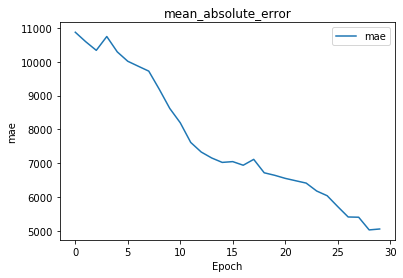

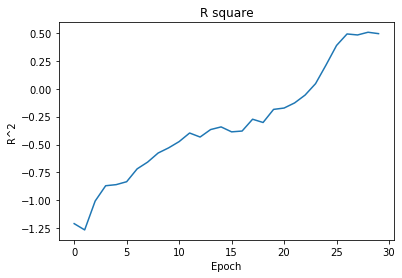

In [36]:
#		2.4.3 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [37]:
#		2.4.4 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_temp_x)
predit = predit_y.reshape(predit_y.shape[0])

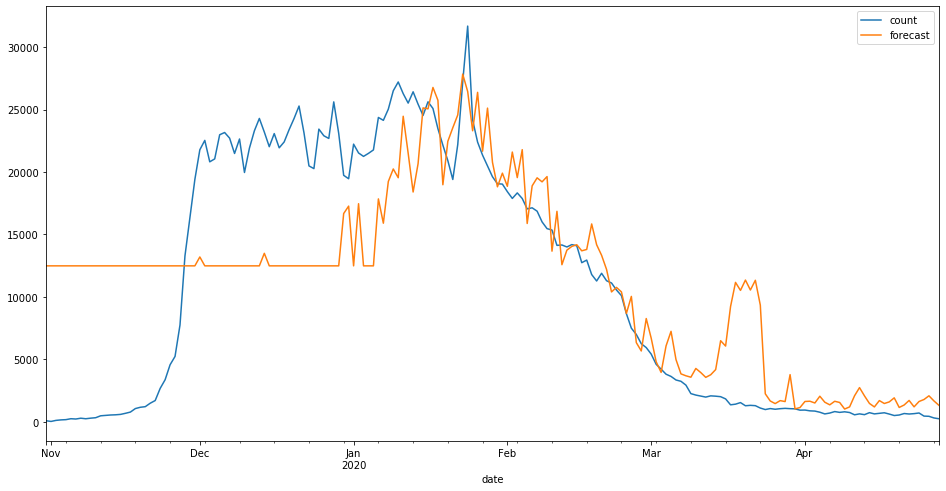

In [38]:
#		2.4.5 실등록자 count와 news기반 예측 count의 비교 chart
predit_result = ar.copy()
predit_result['forecast'] = predit
predit_result.plot(x='date',y=['count','forecast'],figsize=(16,8))

In [39]:
#	2.5 doc2vec에 의한 Forecast regression
#		2.5.1 doc2vec의 Window 적용 Timeseries Trainset의 구성

# 2D Convolution을 적용하여 마치 Image를 convolution 하듯이 학습할 것임
# window의 depth를 image의 channel 처럼 사용
# tensorflow는 image의 chennel을 channel_last로 사용, 
# 이것을 맞추기 위해 moveaxis 를 적용할 것임
# 여기 돌다가 colab 다운 잘됨... 다운 되면 처음부터 다시!

from numpy import moveaxis
# window를 30일로 설정 -> 그냥 잡은 수치
news_window = 30
#향후 15일 예측
news_forecast_days = 15

# 원시 trainset의 사용...
train_news_org_y = train_temp_y
data = train_temp_x

train_news_x = []
train_news_y = []

for i in range(data.shape[0]-news_window-news_forecast_days + 1):
    sub_x = []
    for j in range(news_window):
        sub_x.append(data[i+j,:,:])
    # change channels first to channels last format
    sub_x = np.asarray(sub_x)
    sub_x = moveaxis(sub_x, 0, 2)        
    train_news_x.append(sub_x)

    sub_y = []
    for z in range(news_forecast_days):
        sub_y.append(train_news_org_y[i + news_window + z])
    train_news_y.append(sub_y)

#train_news_x ,train_news_y 준비
train_news_x = np.asarray(train_news_x)
#train_news_x = train_news_x.reshape(-1,news_window,max_buz_per_day,vec_size)
train_news_y = np.asarray(train_news_y)

test_news_x = np.asarray(data[data.shape[0]-news_window:data.shape[0],:,:])
test_news_x = moveaxis(test_news_x, 0, 2) 

In [40]:
#train_news_x ,train_news_y (사실이거는 그냥 train_y와 동일...)의 내용 확인.
train_news_x.shape,  train_news_y.shape, test_news_x.shape

((137, 300, 768, 30), (137, 15), (300, 768, 30))

In [1]:
#		2.5.2 doc2vec Window 의 Timeseries model 구성

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
# 정성적 비정형 데이터로 정량적 수치 데이터를 추정 하기 때문에... overfit 가능성이 큼
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

#keras.backend.set_image_data_format('channels_last')

model = Sequential()
model.add(Conv2D(64,(3,3), input_shape=(max_buz_per_day,vec_size,news_window)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(32,activation="relu"))
model.add(Dense(news_forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Using TensorFlow backend.


NameError: name 'max_buz_per_day' is not defined

In [ ]:
#		2.5.3 doc2vec의 Window 적용 Timeseries Trainset으로 model training

epochs=10
hist = model.fit(train_news_x, train_news_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])


learning:[..........] 0/10 []

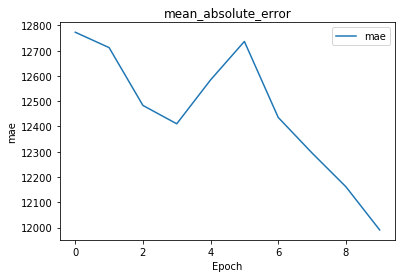

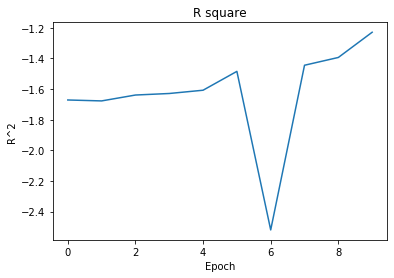

In [98]:
#		2.5.4 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [99]:
#		2.5.5 trainset에 의한 과거 data의 예측 입국자 추정 

predit_news_y = model.predict(train_news_x)
predit_news_y,predit_news_y.shape

(array([[  483.6541 ,   491.10556,   497.37433, ...,   316.25815,
           313.603  ,   327.91272],
        [  483.6541 ,   491.10556,   497.37433, ...,   316.25815,
           313.603  ,   327.91272],
        [  496.5496 ,   504.58386,   510.60925, ...,   325.12033,
           322.23   ,   336.95508],
        ...,
        [11830.519  , 12003.497  , 12171.868  , ...,  7724.4307 ,
          7663.4736 ,  8010.943  ],
        [12023.115  , 12196.538  , 12369.487  , ...,  7847.527  ,
          7786.106  ,  8138.9976 ],
        [12125.416  , 12299.233  , 12477.412  , ...,  7912.45   ,
          7851.705  ,  8207.302  ]], dtype=float32),
 (137, 15))

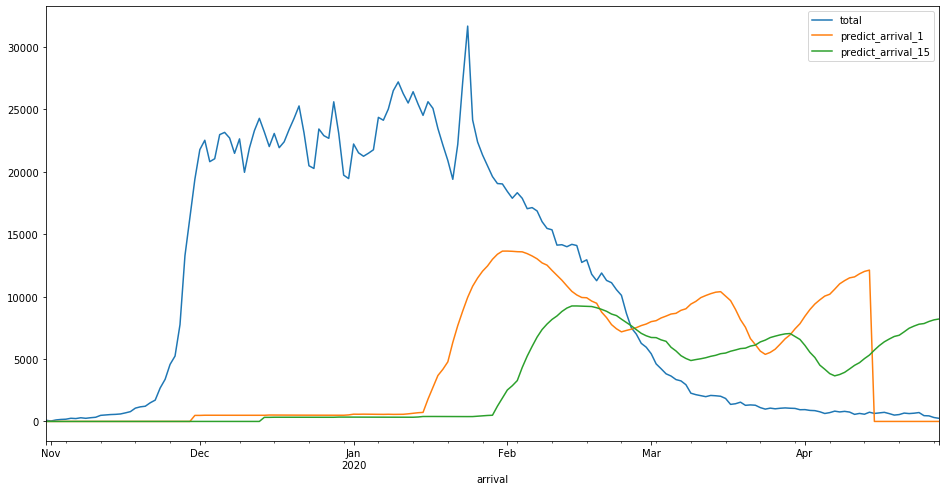

In [100]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
compare_backdata(predit_news_y)

In [72]:
# 	2.6  향후 15일 예측
# 		2.6.1 testset (마지막 30일)의 inference

test_news_x = test_news_x.reshape(-1,max_buz_per_day,vec_size,news_window)
predit_y = model.predict(test_news_x)
predit_y,predit_y.shape

(array([[1567.9517, 1430.1058, 1655.1926, 1307.383 , 1456.2682, 1441.3124,
         1569.1815, 1392.4769, 1356.2214, 1453.4943, 1262.5428, 1487.7052,
         1162.3163, 1429.3203, 1294.0319]], dtype=float32),
 (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,4444.367188,18518
1,2020-04-30,4453.938477,18558
2,2020-05-01,4599.458496,19164
3,2020-05-02,4006.129395,16692
4,2020-05-03,4163.064941,17346
5,2020-05-04,4310.327148,17959
6,2020-05-05,4466.792480,18611
7,2020-05-06,4353.223633,18138
8,2020-05-07,3785.844727,15774
9,2020-05-08,3642.043945,15175


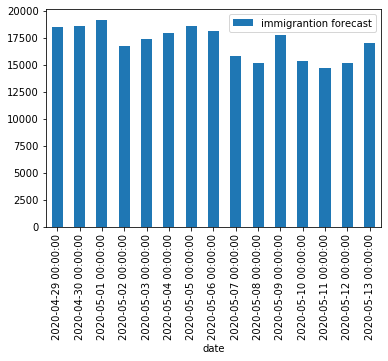

In [42]:
# 		2.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [73]:
# 이제 긴 학습을 해야 해서..
# 돌다가 죽을 것을 대비해서 입출력 dataset을 일단 저장 한다.

from numpy import save
# define data
data = np.asarray([train_x,train_y,test_x,train_news_x,train_news_y,test_news_x])
# save to npy file
save('dataset.npy', data)

In [74]:
if True==0:
    # load numpy array from npy file
    from numpy import load
    # load dict of arrays
    [train_x,train_y,test_x,train_news_x,train_news_y,test_news_x] = load('dataset.npy', allow_pickle=True)

train_x.shape

(137, 30, 174)

In [88]:
#	3.2 Numeric timeseries and unstructured timeseries combined model 구성
import keras
from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate

# custom R2-score metrics for keras backend
from keras import backend as K

# define two sets of inputs
input_roaming = Input(shape=(window, size))
input_news = Input(shape=(max_buz_per_day,vec_size,news_window))

# 로밍등록자에 대한 1D Convilution layer 구성
x = Conv1D(128,4, activation="relu",padding="same")(input_roaming)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(32,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Model(inputs=input_roaming, outputs=x)


# news에 대한 2D Convolution layer 구성
y = Conv2D(64,(3,3), activation="relu")(input_news)
y = MaxPooling2D(pool_size=(3,3))(y)
y = Conv2D(32,(2,2), activation="relu")(y)
y = MaxPooling2D(pool_size=(3,3))(y)
y = Flatten()(y)
y = Dense(1024,activation="relu")(y)
#y = Dropout(0.5)(y)
y = Dense(32,activation="relu")(y)
y = Model(inputs=input_news, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(forecast_days, activation="linear")(combined)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

print(model.summary())

model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

print("save to combined_model.json")

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 30, 174)      0                                            
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 30, 128)      89216       input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 300, 20, 30)  0                                            
__________________________________________________________________________________________________
max_pooling1d_19 (MaxPooling1D) (None, 15, 128)      0           conv1d_22[0][0]                  
___________________________________________________________________________________________

In [89]:
#	3.3 Numeric timeseries and unstructured timeseries data train

def train_combined_model(trial,epochs=30,verbose=0):
    from keras.models import model_from_json
    json_file = open("combined_model.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae','acc'])
    #print(model.summary())
    print(str(trial),"th Trial")
    if verbose == 0:
        hist = model.fit([train_x,train_news_x], train_y, epochs=epochs,verbose=0,callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit([train_x,train_news_x], train_y, epochs=epochs,verbose=1)
    return model,hist

model,hist = train_combined_model(1,epochs=2)

1 th Trial
learning:[==] 2/2 {'loss': 108401430.42335767, 'mae': 8234.738, 'acc': 0.38686132}


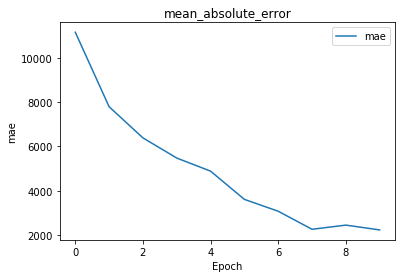

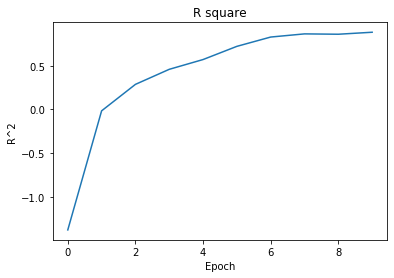

In [77]:
#		3.3.1 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [78]:
#		3.3.2 trainset에 의한 과거 data의 예측 입국자 count 

predit_y = model.predict([train_x,train_news_x])
predit_y,predit_y.shape

(array([[ 8166.213  ,  8175.3535 ,  8809.898  , ...,  9648.949  ,
          8905.425  ,  8881.696  ],
        [10958.873  , 10957.378  , 11825.8    , ..., 12999.796  ,
         11978.215  , 12022.246  ],
        [13880.482  , 13869.52   , 15029.928  , ..., 16479.72   ,
         15223.743  , 15395.3545 ],
        ...,
        [  617.5597 ,   639.03894,   628.35315, ...,   405.79144,
           364.02985,   325.93152],
        [  604.6073 ,   629.00525,   612.1487 , ...,   401.90808,
           368.4408 ,   329.87842],
        [  592.45044,   616.7271 ,   597.4231 , ...,   399.01672,
           369.0478 ,   330.30753]], dtype=float32),
 (137, 15))

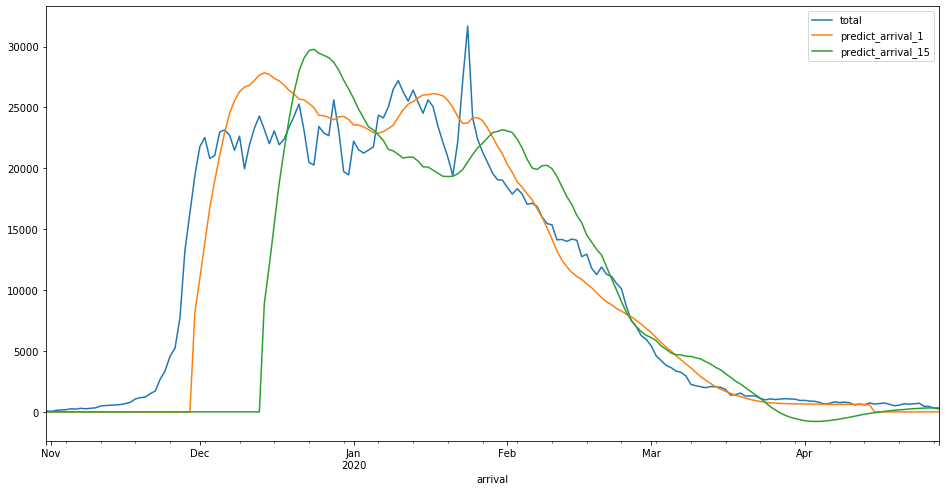

In [79]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
compare_backdata(predit_y)

In [80]:
# 	3.4  향후 15일 예측
# 		3.4.1 testset (마지막 30일)의 inference

predit_y = model.predict([test_x,test_news_x])
predit_y,predit_y.shape

(array([[470.35056, 483.44962, 466.5027 , 427.92148, 458.34576, 423.5922 ,
         367.374  , 438.0581 , 391.18292, 390.96173, 404.6571 , 372.94894,
         335.53146, 343.28748, 321.39862]], dtype=float32),
 (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,470.350555,1959
1,2020-04-30,483.449615,2014
2,2020-05-01,466.502686,1943
3,2020-05-02,427.921478,1783
4,2020-05-03,458.345764,1909
5,2020-05-04,423.592194,1764
6,2020-05-05,367.373993,1530
7,2020-05-06,438.058105,1825
8,2020-05-07,391.182922,1629
9,2020-05-08,390.961731,1629


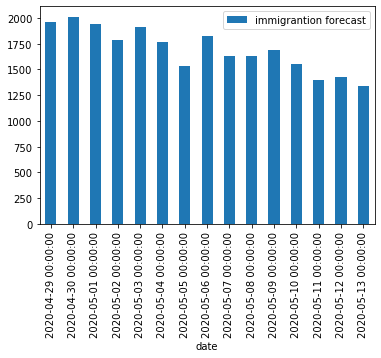

In [81]:
# 		3.4.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [91]:
#	3.5 ensemble에 의한 일관된 결과 예측
#		3.5.1 ensemble model 생성

# 일관된 예측 결과를 만들기 위해, 동일 모델 10개의 앙상블 처리
# 시간 무지 오래 걸림 식사하고 오세요~
# 밥먹고 왔는데 중간에 실패 (Resource exhaustion) 되어 있을 수 있음...
# 너무 오래 걸리면, epoch=200 을 조정 한다.
import dill

ensemble = []
for i in range(2):
  model,hist = train_combined_model(i+1,epochs=2,verbose=0)
  ensemble.append(model)
    
print("Wait! saving model...")    
file = open("ensemble.mdl", 'wb')
dill.dump(ensemble, file)
file.close()
        
print("Complete!!")


1 th Trial
learning:[==] 2/2 {'loss': 106064724.20437956, 'mae': 8264.592, 'acc': 0.03649635}
2 th Trial
learning:[==] 2/2 {'loss': 93272686.3649635, 'mae': 7662.4473, 'acc': 0.02189781}94}
Wait! saving model...
Complete!!


In [92]:
if True == 1:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()

# 		ensemble_predict method define~
def ensemble_predict(input_roam,input_news):

    ensemble_predit_y =  np.asarray([m.predict([input_roam,input_news]) for m in ensemble])
    predit_y = np.mean(ensemble_predit_y,axis=0)
    return predit_y  

load from model file...


In [93]:
# trainset에 의한 과거 data의 예측 입국자 count 

predit_y = ensemble_predict(train_x,train_news_x)
predit_y,predit_y.shape

(array([[1454.8618, 1341.3677, 1642.5879, ..., 1517.7333, 1477.5427,
         1275.5654],
        [1881.94  , 1736.8428, 2119.0366, ..., 1988.1199, 1928.3378,
         1646.5934],
        [2390.962 , 2196.547 , 2680.6392, ..., 2554.4556, 2453.9478,
         2121.4321],
        ...,
        [1690.4011, 1610.4551, 1427.3438, ..., 1220.7158, 1175.4958,
         1329.4995],
        [1601.1267, 1528.0276, 1360.685 , ..., 1165.6377, 1122.4569,
         1260.7192],
        [1516.5452, 1458.0227, 1296.9839, ..., 1117.3247, 1073.4426,
         1195.729 ]], dtype=float32),
 (137, 15))

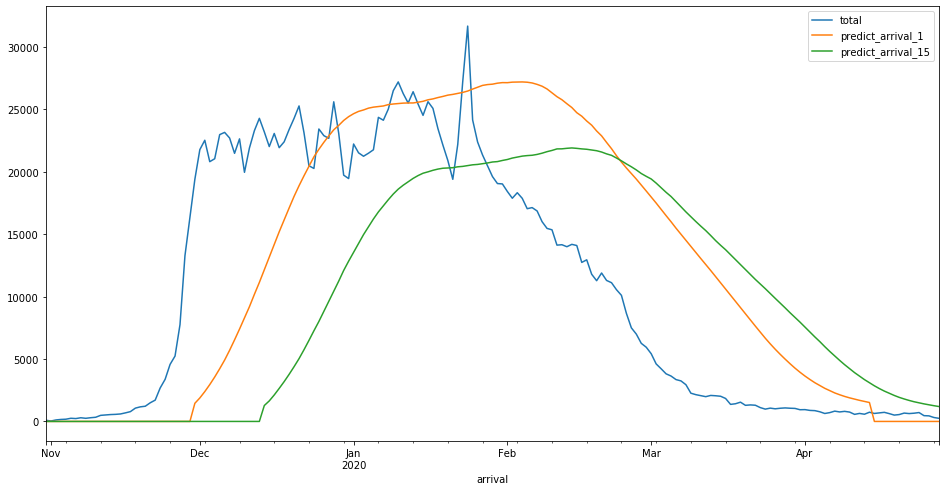

In [94]:
compare_backdata(predit_y)

In [73]:
# 
test_x = test_x.reshape(-1,window,size)
test_news_x = test_news_x.reshape(-1,max_buz_per_day,vec_size,news_window)

predit_y = ensemble_predict(test_x,test_news_x)
predit_y, predit_y.shape

(array([[682.4151 , 709.5459 , 620.25616, 255.07553, 449.54132, 558.4869 ,
         488.46152, 724.5994 , 557.08655, 596.8591 , 696.68146, 423.2028 ,
         453.44028, 647.7956 , 311.1008 ]], dtype=float32),
 (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,682.415100,2843
1,2020-04-30,709.545898,2956
2,2020-05-01,620.256165,2584
3,2020-05-02,255.075531,1062
4,2020-05-03,449.541321,1873
5,2020-05-04,558.486877,2327
6,2020-05-05,488.461517,2035
7,2020-05-06,724.599426,3019
8,2020-05-07,557.086548,2321
9,2020-05-08,596.859070,2486


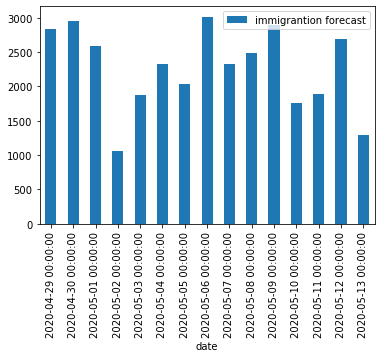

In [74]:
#		3.5.2 최종 결과
display_result(predit_y)